In [1]:
# Import dependencies
import praw
from psaw import PushshiftAPI
import pandas as pd
import datetime
import time
import matplotlib.pyplot as plt 
from config import client_id, client_secret, user_agent
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/adamweber/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
# Set up API credentials
reddit = praw.Reddit(client_id = client_id,
                     client_secret = client_secret,
                     user_agent = user_agent)
api = PushshiftAPI()

In [3]:
from datetime import timezone

# Getting date ranges per day and converting to UTC timestamp
import datetime
start_date = datetime.datetime(2020, 1, 1)
end_date = datetime.datetime(2020, 1, 4)
delta = datetime.timedelta(days=1)

stopper = start_date

while start_date <= end_date:
    stopper += delta
    
    start = int(start_date.replace(tzinfo=timezone.utc).timestamp())
    end = int(stopper.replace(tzinfo=timezone.utc).timestamp())
    print(start, "to", end)
    start_date += delta

1577836800 to 1577923200
1577923200 to 1578009600
1578009600 to 1578096000
1578096000 to 1578182400


In [4]:
# Start timer for this section
start_time = time.time()

# Start with a clear list for query
submissions = list()

# Start end end dates
start_date = datetime.datetime(2012, 1, 1)
end_date = datetime.datetime(2020, 9, 14)
delta = datetime.timedelta(days=1)
stopper = start_date

while start_date <= end_date:
    
    # This is our end time for each day range
    stopper += delta
    
    # Convert dates to timestamp
    start = int(start_date.replace(tzinfo=timezone.utc).timestamp())
    end = int(stopper.replace(tzinfo=timezone.utc).timestamp())
    
    # API queries we need a high search limit so that we get an even spread of comments across the whole day
    query1 = api.search_comments(subreddit='cryptocurrency',
                                 q="bitcoin|btc",
                                 after=start,
                                 before=end,
                                 limit=10000)
    
    query2 = api.search_comments(subreddit='bitcoin',
                                 q="bitcoin|btc",
                                 after=start,
                                 before=end,
                                 limit=10000)
    
    query3 = api.search_comments(subreddit='btc',
                                 q="bitcoin|btc",
                                 after=start,
                                 before=end,
                                 limit=10000)
    
    # Get query results and store
    for element in query1:
        submissions.append(element.d_)
    for element in query2:
        submissions.append(element.d_)
    for element in query3:
        submissions.append(element.d_)
    
    # This is our start time for each day range
    start_date += delta

print("Total comments: ", len(submissions))
print("Scraping took", time.time() - start_time, "to run")

/Users/adamweber/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/psaw/PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
/Users/adamweber/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/psaw/PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")
/Users/adamweber/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/psaw/PushshiftAPI.py:244: UserWarning: Not all PushShift shards are active. Query results may be incomplete
  warnings.warn(shards_down_message)


Total comments:  3135917
Scraping took 45312.01809501648 to run


In [5]:
# Convert to dataframe
df = pd.DataFrame(submissions)
# Keep only the needed columns
df = df[['id', 'score', 'subreddit', 'body', 'created_utc']]
# Convert to datetime and sort by it
df['datetime'] = df['created_utc'].map(lambda t: datetime.datetime.fromtimestamp(t))
df = df.drop('created_utc', axis=1)
df = df.sort_values(by='datetime')
df

,id,score,subreddit,body,datetime
11,c3cuohg,2,Bitcoin,Good to know. My bitcoin wallet is the only se...,2011-12-31 17:29:45
10,c3cxmid,3,Bitcoin,The last trade for 2011 at the leading Bitcoin...,2012-01-01 02:11:54
9,c3cxn79,7,Bitcoin,"Keep in mind, this is occurring during a ""hype...",2012-01-01 02:17:20
8,c3cyiit,3,Bitcoin,Consider also:\n\n&gt; No regulations\n\nRemem...,2012-01-01 07:07:50
7,c3cylii,8,Bitcoin,The Obama administration is also preparing to ...,2012-01-01 07:28:20
...,...,...,...,...,...
3135370,g5awjq8,2,Bitcoin,Does it accept bitcoin for the ride?,2020-09-14 16:54:15
3135192,g5awke1,1,CryptoCurrency,"BTC doesn't compete with fiat/stable-coins, it...",2020-09-14 16:54:25
3135369,g5awqm7,1,Bitcoin,Is investing in bitcoin success then?,2020-09-14 16:56:02
3135368,g5ax3iq,3,Bitcoin,Amateur... I've been 200% BTC since 1928,2020-09-14 16:59:18


In [6]:
# Lots of duplicates. Most seem to be spam/bots
duplicateRowsDF = df[df.duplicated(['body'])]
len(duplicateRowsDF)

81808

In [7]:
# Removing duplicates
df = df.drop_duplicates(subset='body', keep="first")
df

,id,score,subreddit,body,datetime
11,c3cuohg,2,Bitcoin,Good to know. My bitcoin wallet is the only se...,2011-12-31 17:29:45
10,c3cxmid,3,Bitcoin,The last trade for 2011 at the leading Bitcoin...,2012-01-01 02:11:54
9,c3cxn79,7,Bitcoin,"Keep in mind, this is occurring during a ""hype...",2012-01-01 02:17:20
8,c3cyiit,3,Bitcoin,Consider also:\n\n&gt; No regulations\n\nRemem...,2012-01-01 07:07:50
7,c3cylii,8,Bitcoin,The Obama administration is also preparing to ...,2012-01-01 07:28:20
...,...,...,...,...,...
3135370,g5awjq8,2,Bitcoin,Does it accept bitcoin for the ride?,2020-09-14 16:54:15
3135192,g5awke1,1,CryptoCurrency,"BTC doesn't compete with fiat/stable-coins, it...",2020-09-14 16:54:25
3135369,g5awqm7,1,Bitcoin,Is investing in bitcoin success then?,2020-09-14 16:56:02
3135368,g5ax3iq,3,Bitcoin,Amateur... I've been 200% BTC since 1928,2020-09-14 16:59:18


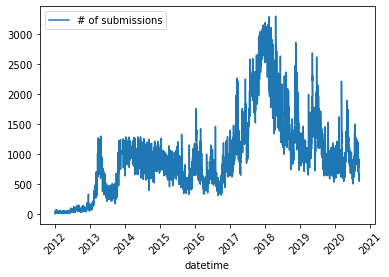

In [8]:
# Display # of results by date
df.groupby(by=df.datetime.dt.date).count().plot(y='id', rot=45, label='# of submissions')

In [9]:
# Get sentiment scores for df
analyzer = SentimentIntensityAnalyzer()

df['neg'] = df['body'].apply(lambda x:analyzer.polarity_scores(x)['neg'])
df['neu'] = df['body'].apply(lambda x:analyzer.polarity_scores(x)['neu'])
df['pos'] = df['body'].apply(lambda x:analyzer.polarity_scores(x)['pos'])
df['compound'] = df['body'].apply(lambda x:analyzer.polarity_scores(x)['compound'])
df

/Users/adamweber/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/adamweber/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/adamweber/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

,id,score,subreddit,body,datetime,neg,neu,pos,compound
11,c3cuohg,2,Bitcoin,Good to know. My bitcoin wallet is the only se...,2011-12-31 17:29:45,0.000,0.704,0.296,0.8957
10,c3cxmid,3,Bitcoin,The last trade for 2011 at the leading Bitcoin...,2012-01-01 02:11:54,0.000,0.961,0.039,0.3182
9,c3cxn79,7,Bitcoin,"Keep in mind, this is occurring during a ""hype...",2012-01-01 02:17:20,0.048,0.943,0.009,-0.5574
8,c3cyiit,3,Bitcoin,Consider also:\n\n&gt; No regulations\n\nRemem...,2012-01-01 07:07:50,0.085,0.729,0.187,0.8778
7,c3cylii,8,Bitcoin,The Obama administration is also preparing to ...,2012-01-01 07:28:20,0.110,0.890,0.000,-0.4939
...,...,...,...,...,...,...,...,...,...
3135370,g5awjq8,2,Bitcoin,Does it accept bitcoin for the ride?,2020-09-14 16:54:15,0.000,0.698,0.302,0.3818
3135192,g5awke1,1,CryptoCurrency,"BTC doesn't compete with fiat/stable-coins, it...",2020-09-14 16:54:25,0.000,0.898,0.102,0.1779
3135369,g5awqm7,1,Bitcoin,Is investing in bitcoin success then?,2020-09-14 16:56:02,0.000,0.575,0.425,0.5719
3135368,g5ax3iq,3,Bitcoin,Amateur... I've been 200% BTC since 1928,2020-09-14 16:59:18,0.000,1.000,0.000,0.0000


In [10]:
# View overall subreddit scores
df.groupby('subreddit')['compound'].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
Bitcoin,1842534.0,0.185812,0.544253,-0.9999,-0.1779,0.2144,0.6702,0.9999
CryptoCurrency,466443.0,0.167786,0.534055,-0.9997,-0.2006,0.1601,0.6369,0.9998
btc,745132.0,0.114508,0.577243,-0.9999,-0.3595,0.1260,0.6239,0.9997


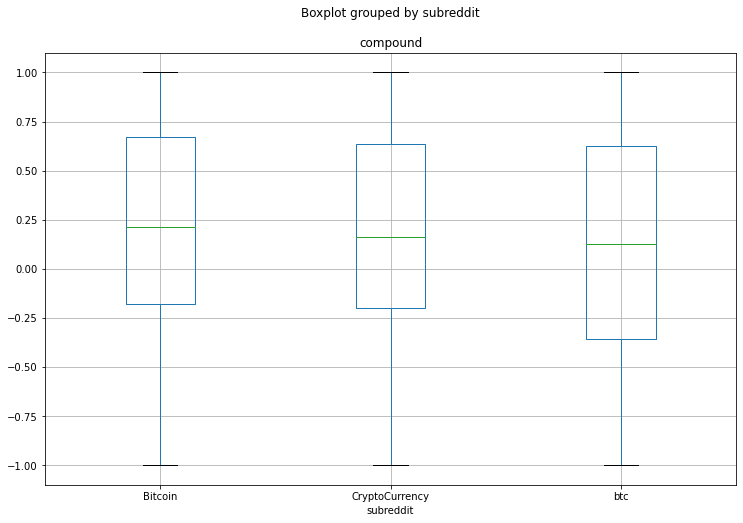

In [11]:
# Display above scores as a boxplot
df.boxplot(by='subreddit', column='compound', figsize=(12,8))

In [12]:
df.index = pd.to_datetime(df['datetime'])
df['rolling'] = df['compound'].rolling('6h').mean()

/Users/adamweber/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


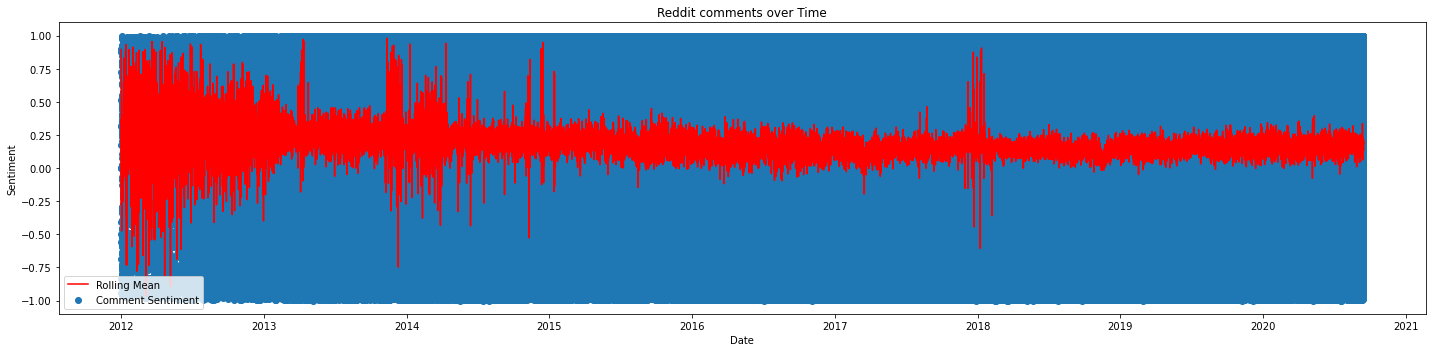

In [13]:
# View sentiment across entire dataset
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.scatter(df['datetime'],df['compound'], label='Comment Sentiment')
ax.plot(df['datetime'],df['rolling'], color ='r', label='Rolling Mean')
ax.set(title='Reddit comments over Time', xlabel='Date', ylabel='Sentiment')
ax.legend(loc='best')
fig.tight_layout()
plt.show()

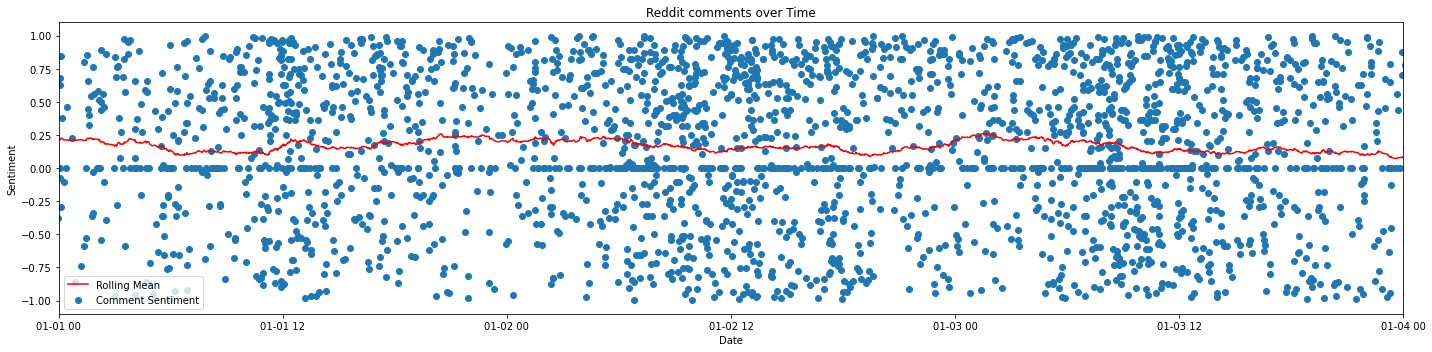

In [14]:
# View small sample of sentiment
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.scatter(df['datetime'],df['compound'], label='Comment Sentiment')
ax.plot(df['datetime'],df['rolling'], color ='r', label='Rolling Mean')
ax.set_xlim([datetime.date(2020,1,1),datetime.date(2020,1,4)])
ax.set(title='Reddit comments over Time', xlabel='Date', ylabel='Sentiment')
ax.legend(loc='best')
fig.tight_layout()
plt.show()

In [16]:
# Export to csv
df.to_csv('Resources/reddit_comments.csv', index=False)